# Training the Models
---

This notebook is used for training the models

## 1. Importing libraries

In [1]:
# Import libraries
import sys
import torch
import torchio as tio

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders, add_vessel_contrast
# from src.config import config
from src.drr import create_drr
from src.vizualization import plot_results
import src.training
from diffdrr.data import read, transform_hu_to_density
from src.model import TACEnet

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Non deformation model

Below is a short demo of training the non deformation model. 

[1/10] - Loss: 1.5928856134414673
[2/10] - Loss: 1.5512844324111938
[3/10] - Loss: 1.5332229137420654
[4/10] - Loss: 1.5243804454803467
[5/10] - Loss: 1.5101368427276611
[6/10] - Loss: 1.5192246437072754
[7/10] - Loss: 1.5048763751983643
[8/10] - Loss: 1.495262622833252
[9/10] - Loss: 1.4919564723968506
[10/10] - Loss: 1.482800006866455


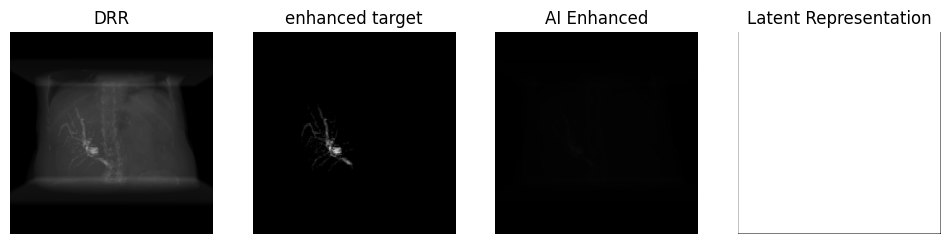

[1/10] - Loss: 1.495617389678955
[2/10] - Loss: 1.4696060419082642
[3/10] - Loss: 1.466841459274292
[4/10] - Loss: 1.4637898206710815
[5/10] - Loss: 1.4220823049545288
[6/10] - Loss: 1.464769959449768
[7/10] - Loss: 1.4444843530654907
[8/10] - Loss: 1.4435250759124756
[9/10] - Loss: 1.4187465906143188
[10/10] - Loss: 1.3912562131881714


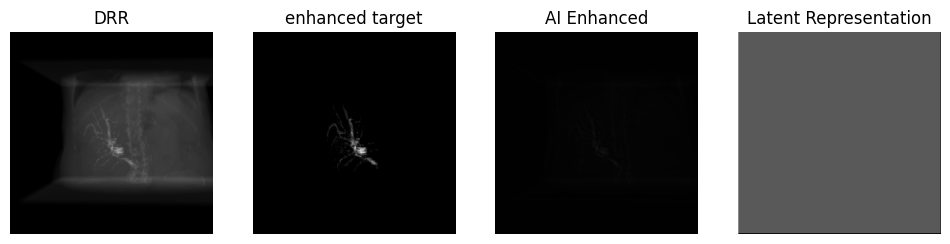

[1/10] - Loss: 1.3607779741287231
[2/10] - Loss: 1.3327232599258423
[3/10] - Loss: 1.3637094497680664
[4/10] - Loss: 1.30686354637146
[5/10] - Loss: 1.2870440483093262
[6/10] - Loss: 1.3375027179718018
[7/10] - Loss: 1.2994071245193481
[8/10] - Loss: 1.3228328227996826
[9/10] - Loss: 1.3623496294021606
[10/10] - Loss: 1.28748619556427


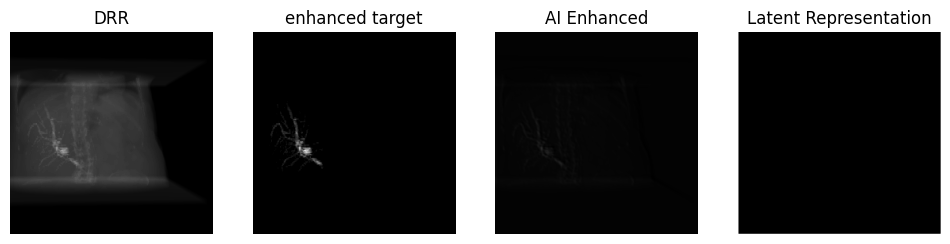

[1/10] - Loss: 1.2199254035949707
[2/10] - Loss: 1.255885362625122
[3/10] - Loss: 1.252474069595337
[4/10] - Loss: 1.1571918725967407
[5/10] - Loss: 1.1066519021987915
[6/10] - Loss: 1.2302470207214355
[7/10] - Loss: 1.0621248483657837
[8/10] - Loss: 1.0320061445236206
[9/10] - Loss: 1.0852118730545044
[10/10] - Loss: 1.02060866355896


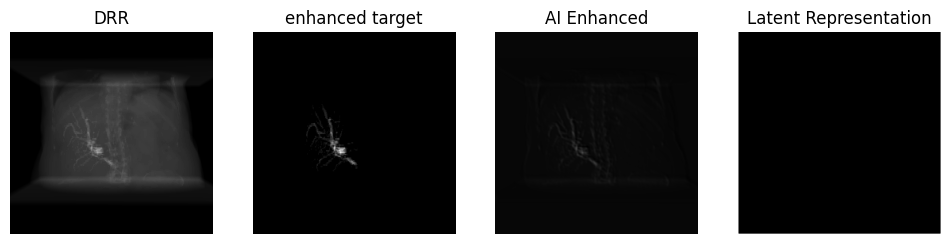

[1/10] - Loss: 1.0982850790023804
[2/10] - Loss: 0.9964359998703003
[3/10] - Loss: 1.0771063566207886
[4/10] - Loss: 0.9588796496391296
[5/10] - Loss: 0.8119112849235535
[6/10] - Loss: 1.0366179943084717
[7/10] - Loss: 1.005511999130249
[8/10] - Loss: 0.9402894377708435
[9/10] - Loss: 0.7103167772293091
[10/10] - Loss: 0.8441991209983826


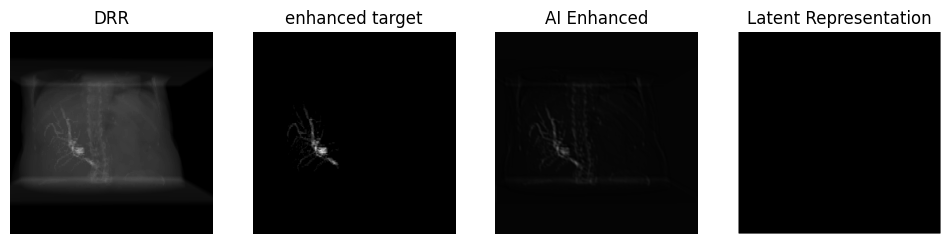

In [2]:
src.training.trainModel(5,10, save=False, load=False, path="../models/TACEnet_vessel_enhancement_2_0.pth", verbose=True)

## 3. Deformation model

Below follows a demo of training the deformation model

In [3]:
# Get transforms
transform = get_transforms(resize_shape= [512, 512, 96], contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data081",
    collection="HCC-TACE-Seg",
    transform=transform,
    download=False,
    val_frac=0.0,
    download_len=1,
    seed=42
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets to make sure data split is correct
print(train_ds.get_indices(), val_ds.get_indices())

# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
volumes, targets = batch["image"], batch["seg"]

print(volumes.shape, targets.shape)

[0] []
torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 1, 512, 512, 96])


In [4]:
# Define model
model = TACEnet()

# Move model to device
model.to(device)

# Initialize the criterion, DICE loss with cross entropy uses binary cross entropy when there are only two classes
criterion = torch.nn.MSELoss()

# Initialize the optimizer, use config to set hyperparameters
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)

volumes = add_vessel_contrast(volumes, targets, contrast_value=4000)

c:\Users\Sven\anaconda3\envs\torch\Lib\site-packages\torchio\transforms\augmentation\spatial\random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
c:\Users\Sven\anaconda3\envs\torch\Lib\site-packages\torch\_tensor.py:1418: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


Epoch [1/5], Step [1/1], Loss: 0.9728062152862549


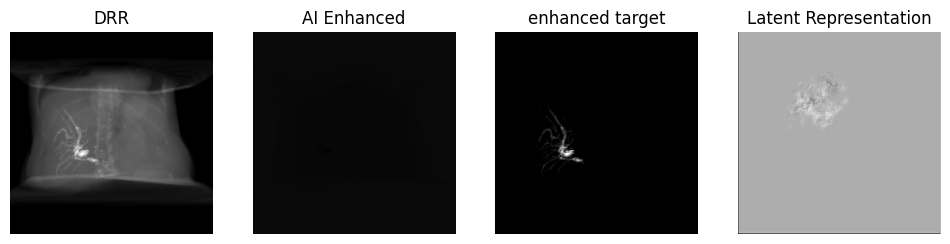

Epoch [2/5], Step [1/1], Loss: 1.2726126909255981


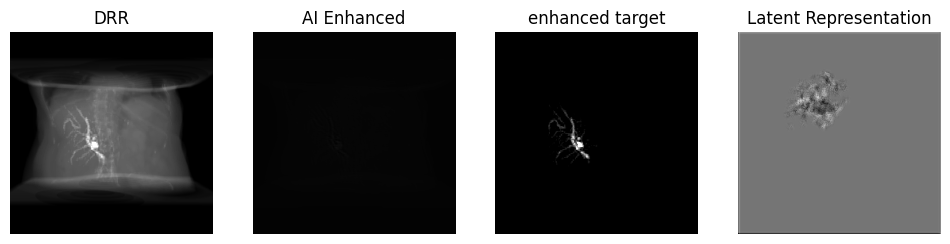

Epoch [3/5], Step [1/1], Loss: 1.6677085161209106


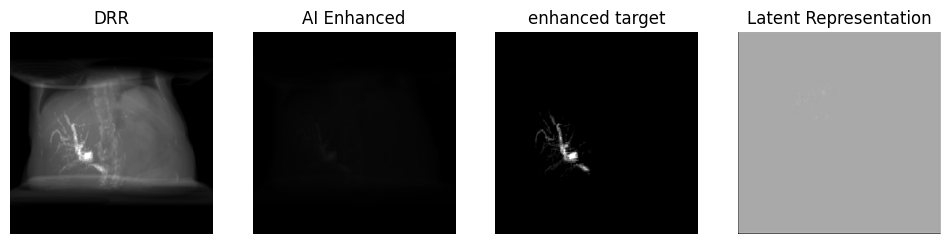

Epoch [4/5], Step [1/1], Loss: 1.368072271347046


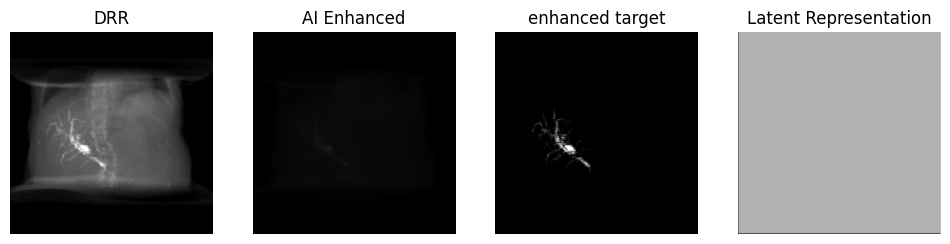

Epoch [5/5], Step [1/1], Loss: 1.2527068853378296


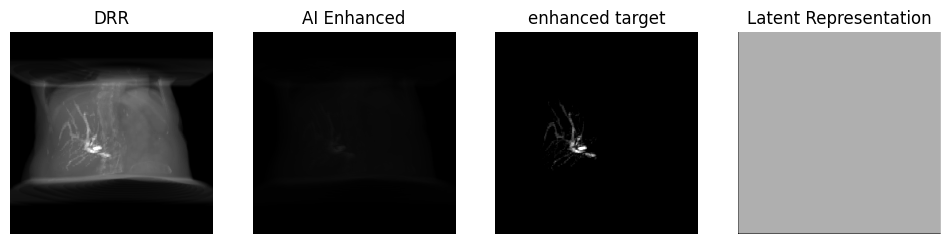

In [5]:
num_epochs = 5


# Training loop
for epoch in range(num_epochs):
    for i in range(len(volumes)): 
        rotation = 0
        
        # Read the image and segmentation subject
        subject = read(
            tensor=volumes[i],
            label_tensor=targets[i],
            orientation="AP",
            bone_attenuation_multiplier=5.0,
        )

        # Create a RandomElasticDeformation transform
        deform = tio.RandomElasticDeformation(p=1.0, num_control_points=7, max_displacement=50)

        # Apply the transform to the subject
        deformed_subject = deform(subject)

        deformed_subject.density = transform_hu_to_density(
            deformed_subject.volume.data, 5.0
        )
        
        # Create raw DRR
        drr_raw = create_drr(
            deformed_subject,
            sdd=1020,
            height=256,
            width=256,
            rotations=torch.tensor([[rotation, 0.0, 0.0]]),
            translations=torch.tensor([[0.0, 850.0, 0.0]]),
            mask_to_channels=True,
            device="cpu",
        )

        # Extract DRR body and vessels
        drr_body = drr_raw[:, 0]
        drr_vessels = drr_raw[:, 1]

        # Combine DRR body and vessels with enhancement factors
        ef = 0.6
        drr_combined_low_enhancement = (drr_body + ef * drr_vessels).unsqueeze(0)
    
        # Move tensors to the appropriate device
        drr_combined_low_enhancement = drr_combined_low_enhancement.to(device)
        drr_combined_target = drr_vessels.to(device)

        # Forward pass
        prediction, latent_representation = model(targets.to(device), drr_combined_low_enhancement)

        # Compute loss
        loss = criterion(prediction, drr_combined_target)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(volumes)}], Loss: {loss.item()}"
        )

        # Plot the images (optional)
        plot_results(
            drr_combined_low_enhancement, drr_combined_target, prediction,latent_representation, vmax=25
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()